## Tauchen_MATLAB

In [1]:
import numpy as np
from statsmodels.tsa.api import VAR
from scipy.stats import norm
import pandas as pd
from scipy.stats import f
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
B_values = [
    np.array([[0.9, 0.1], [0.05, 0.9]]),
    np.array([[0.8, 0.2], [0.1, 0.8]]),
    np.array([[0.7, 0.3], [0.15, 0.7]])
]

Sigma_values = [
    np.array([[0.1, 0.02], [0.02, 0.1]]),
    np.array([[0.2, 0.05], [0.05, 0.2]]),
    np.array([[0.05, 0.01], [0.01, 0.05]])
]

ny_values = [3, 5, 7, 9, 11, 13, 15]

In [3]:
def tauchen_var(Sigma, B, ny):
    M = B.shape[0]
    nSig = 3

    # Unconditional variance
    Sigy = np.linalg.solve(np.eye(M) - np.dot(B.T, B), Sigma)
    stdy = np.sqrt(np.diag(Sigy))

    # Grid points
    grids = [np.linspace(-nSig * stdy[m], nSig * stdy[m], ny) for m in range(M)]
    G = np.array(np.meshgrid(*grids, indexing="ij")).reshape(M, -1).T

    # Bounds for transitions
    edges = [np.hstack([-np.inf, 0.5 * (grids[m][1:] + grids[m][:-1]), np.inf]) for m in range(M)]
    lower_bounds = np.array(np.meshgrid(*[edges[m][:-1] for m in range(M)], indexing="ij")).reshape(M, -1).T
    upper_bounds = np.array(np.meshgrid(*[edges[m][1:] for m in range(M)], indexing="ij")).reshape(M, -1).T

    # Transition matrix
    N = G.shape[0]
    P = np.zeros((N, N))
    mu = np.dot(G, B.T)
    stde = np.sqrt(np.diag(Sigma))

    for i in range(N):
        for j in range(N):
            prob = 1
            for m in range(M):
                lower = (lower_bounds[j, m] - mu[i, m]) / stde[m]
                upper = (upper_bounds[j, m] - mu[i, m]) / stde[m]
                prob *= max(0, norm.cdf(upper) - norm.cdf(lower))
            P[i, j] = prob

    P /= P.sum(axis=1, keepdims=True)
    return P, G

In [4]:
# Simulate data from the Markov chain with added noise
def simulate_markov_chain_with_noise(P, G, n_steps=1000, noise_std=0.01):
    N = P.shape[0]
    indices = np.arange(N)
    state = np.random.choice(indices)  # Initial state
    states = [state]

    for _ in range(n_steps - 1):
        state = np.random.choice(indices, p=P[state])
        states.append(state)

    simulated_data = G[states]

    # Add small noise to avoid constant columns
    noise = np.random.normal(0, noise_std, simulated_data.shape)
    simulated_data += noise

    return simulated_data

In [5]:
# Fit VAR(1) model and estimate B and Sigma
def fit_var1(data):
    model = VAR(data)
    results = model.fit(1)
    B_hat = results.params[1:].T
    Sigma_hat = results.sigma_u
    return B_hat, Sigma_hat

In [6]:
def evaluate_tauchen_var_combinations_with_noise(B_values, Sigma_values, ny_values, n_steps=1000):
    results = []

    for B in B_values:
        for Sigma in Sigma_values:
            for ny in ny_values:
                # Run the Tauchen method
                P, G = tauchen_var(Sigma, B, ny)

                # Simulate data with added noise
                simulated_data = simulate_markov_chain_with_noise(P, G, n_steps)

                # Fit VAR(1) model on simulated data
                B_hat, Sigma_hat = fit_var1(simulated_data)

                # Compute performance metrics
                B_error = np.linalg.norm(B - B_hat)
                Sigma_error = np.linalg.norm(Sigma - Sigma_hat)

                # Store results
                results.append({
                    "B": B,
                    "Sigma": Sigma,
                    "ny": ny,
                    "Estimated B": B_hat,
                    "Estimated Sigma": Sigma_hat,
                    "B Error": B_error,
                    "Sigma Error": Sigma_error
                })

    return results

evaluation_results_with_tests = evaluate_tauchen_var_combinations_with_noise(B_values, Sigma_values, ny_values)

In [7]:
# Print
def format_matrix(matrix):
    return "\n".join(["[" + " ".join(f"{value:.4f}" for value in row) + "]" for row in matrix])

# Print each case with matrices formatted and spaced
for idx, result in enumerate(evaluation_results_with_tests):
    B_original = result["B"]
    Sigma_original = result["Sigma"]
    ny_value = result["ny"]
    B_estimated = result["Estimated B"]
    Sigma_estimated = result["Estimated Sigma"]
    B_error = result["B Error"]
    Sigma_error = result["Sigma Error"]

    #print(f"Case {idx + 1}:\n")
    #print(f"When B = \n{format_matrix(B_original)},\n")
    #print(f"Sigma = \n{format_matrix(Sigma_original)},\n")
    #print(f"and ny = {ny_value},\n")
    #print(f"we estimate B = \n{format_matrix(B_estimated)}\n")
    #print(f"and Sigma = \n{format_matrix(Sigma_estimated)}.\n")
    #print(f"The performance is measured by B Error = {B_error:.4f} and Sigma Error = {Sigma_error:.4f}.\n")
    #print("\n" + "-" * 80 + "\n")

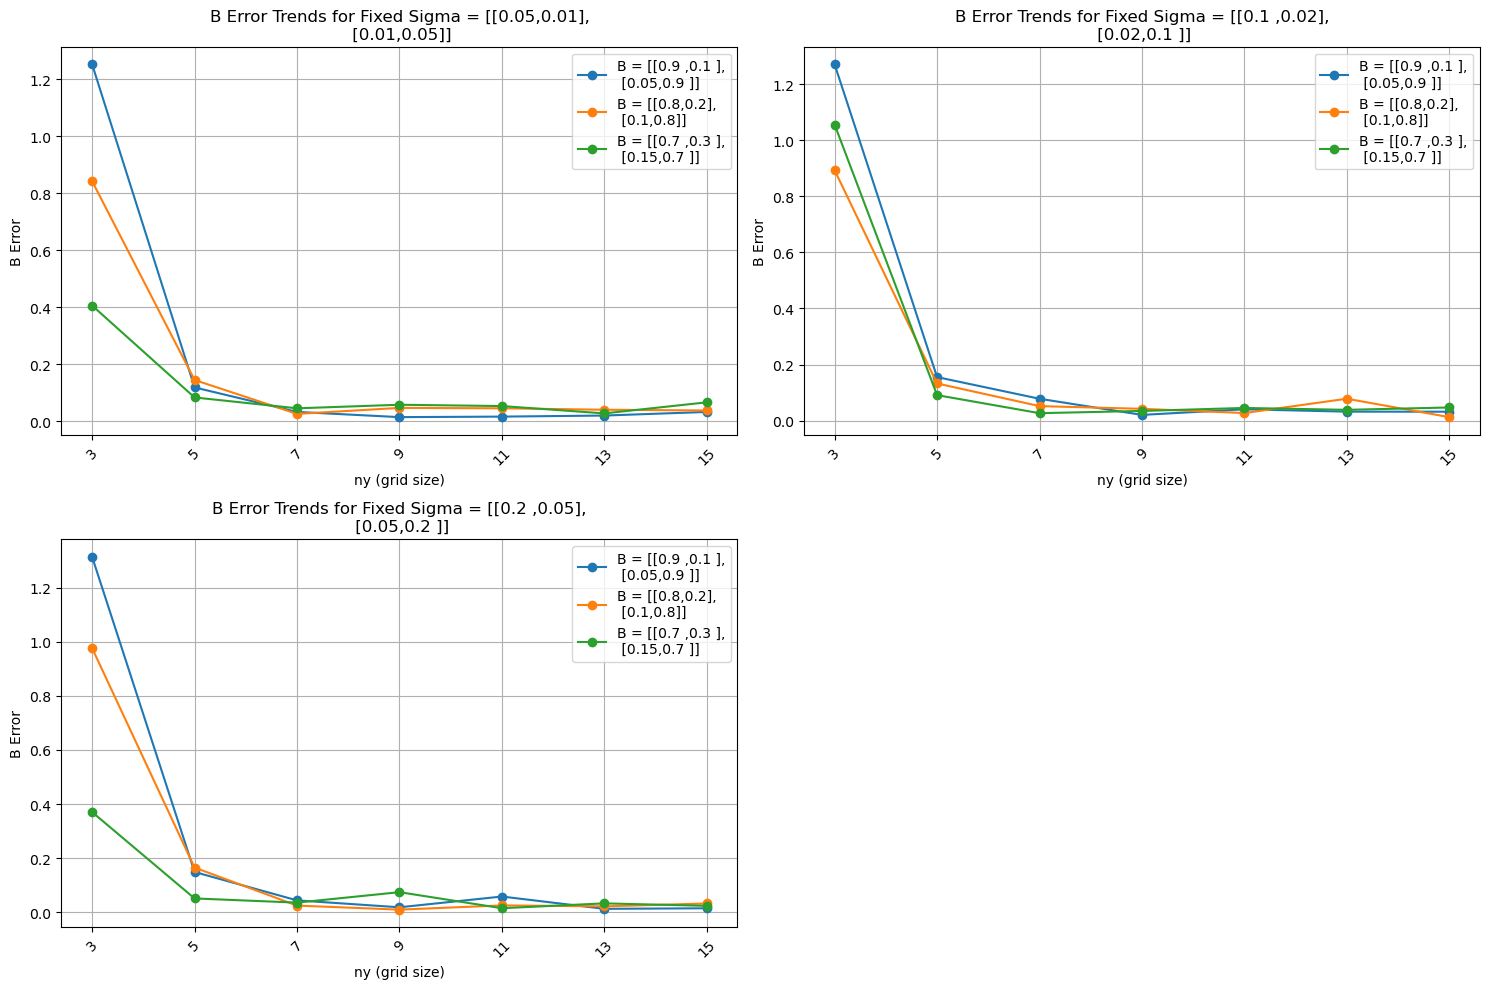

In [8]:
# Plot B error trends for fixed Sigma with proper rows and columns layout
def plot_B_error_trends(evaluation_results):

    unique_sigma_values = set(result["Sigma"].tobytes() for result in evaluation_results)  # Identify unique Sigma
    sigma_to_matrix = {sigma: np.frombuffer(sigma, dtype=np.float64).reshape(2, 2) for sigma in unique_sigma_values}

    # Determine grid dimensions
    num_plots = len(sigma_to_matrix)
    rows = (num_plots + 1) // 2  # Two plots per row
    cols = 2 if num_plots > 1 else 1

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten() if num_plots > 1 else [axes]

    # Process each Sigma
    for idx, (sigma_bytes, sigma_matrix) in enumerate(sigma_to_matrix.items()):
        # Filter results for the current Sigma
        filtered_results = [
            result for result in evaluation_results if result["Sigma"].tobytes() == sigma_bytes
        ]

        # Organize data for plotting
        B_errors_by_B = {}
        ny_values_set = sorted(set(result["ny"] for result in filtered_results))
        for result in filtered_results:
            B = result["B"].tobytes()
            if B not in B_errors_by_B:
                B_errors_by_B[B] = {
                    "B_matrix": result["B"],
                    "errors": [],
                }
            B_errors_by_B[B]["errors"].append(result["B Error"])

        # Create the plot in the corresponding grid location
        ax = axes[idx]
        for B_key, data in B_errors_by_B.items():
            ax.plot(
                ny_values_set,
                data["errors"],
                marker="o",
                label=f"B = {np.array2string(data['B_matrix'], precision=2, separator=',')}",
            )

        ax.set_title(f"B Error Trends for Fixed Sigma = {np.array2string(sigma_matrix, precision=2, separator=',')}")
        ax.set_xlabel("ny (grid size)")
        ax.set_ylabel("B Error")

        ax.set_xticks(ny_values_set)  # Set x-ticks explicitly at ny values
        ax.set_xticklabels([str(ny) for ny in ny_values_set], rotation=45)  # Rotate labels for better readability

        ax.legend()
        ax.grid(True)

    # Hide unused subplots if any
    for idx in range(len(sigma_to_matrix), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


# Plot B error trends for fixed Sigma
plot_B_error_trends(evaluation_results_with_tests)

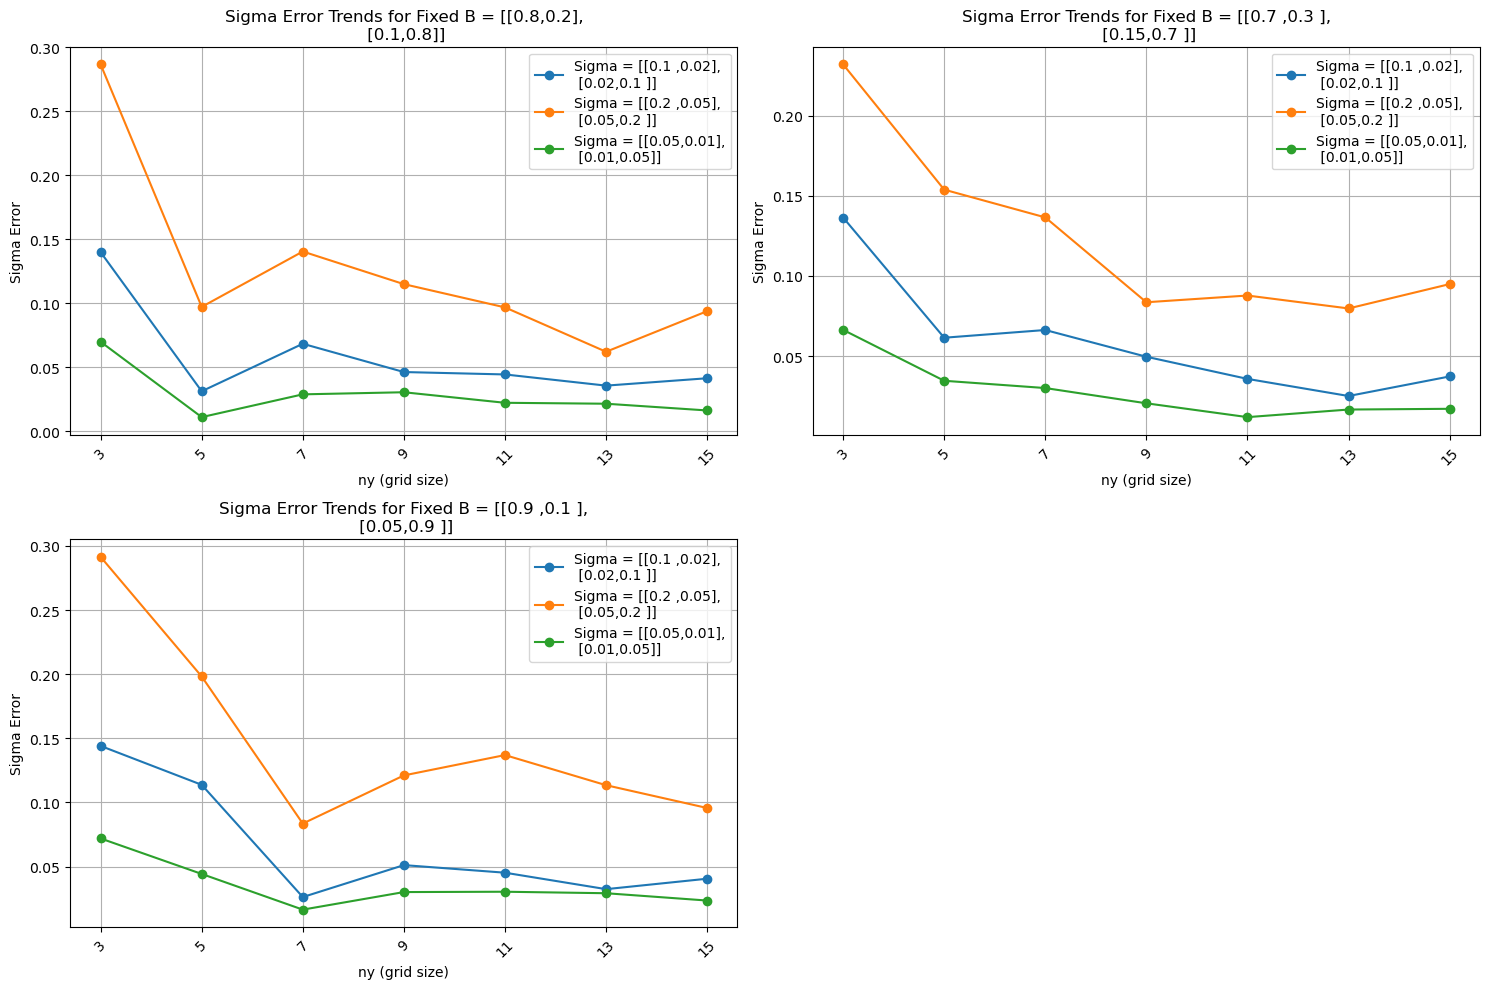

In [9]:
def plot_sigma_error_trends(evaluation_results):
    unique_B_values = set(result["B"].tobytes() for result in evaluation_results)  # Identify unique B matrices
    B_to_matrix = {B: np.frombuffer(B, dtype=np.float64).reshape(2, 2) for B in unique_B_values}

    # Create subplots
    num_plots = len(B_to_matrix)
    rows = (num_plots + 1) // 2  # Two plots per row
    cols = 2 if num_plots > 1 else 1

    fig = plt.figure(figsize=(15, 5 * rows))
    gs = GridSpec(rows, cols, figure=fig)

    # Process each B
    for idx, (B_bytes, B_matrix) in enumerate(B_to_matrix.items()):
        # Filter results for the current B
        filtered_results = [
            result for result in evaluation_results if result["B"].tobytes() == B_bytes
        ]

        # Organize data for plotting
        sigma_errors_by_sigma = {}
        ny_values_set = sorted(set(result["ny"] for result in filtered_results))
        for result in filtered_results:
            Sigma = result["Sigma"].tobytes()
            if Sigma not in sigma_errors_by_sigma:
                sigma_errors_by_sigma[Sigma] = {
                    "Sigma_matrix": result["Sigma"],
                    "errors": [],
                }
            sigma_errors_by_sigma[Sigma]["errors"].append(result["Sigma Error"])

        # Create the plot
        ax = fig.add_subplot(gs[idx // 2, idx % 2])  # Arrange plots in a grid
        for Sigma_key, data in sigma_errors_by_sigma.items():
            ax.plot(
                ny_values_set,
                data["errors"],
                marker="o",
                label=f"Sigma = {np.array2string(data['Sigma_matrix'], precision=2, separator=',')}",
            )

        ax.set_title(f"Sigma Error Trends for Fixed B = {np.array2string(B_matrix, precision=2, separator=',')}")
        ax.set_xlabel("ny (grid size)")
        ax.set_ylabel("Sigma Error")

        ax.set_xticks(ny_values_set)  # Set x-ticks explicitly at ny values
        ax.set_xticklabels([str(ny) for ny in ny_values_set], rotation=45)  # Rotate labels for better readability

        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Plot Sigma error trends for fixed B
plot_sigma_error_trends(evaluation_results_with_tests)